In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd
import numpy as np



# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


#loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

#print(loaded_data)
#print(frequency)
#print(forecast_horizon)
#print(contain_missing_values)
#print(contain_equal_length)

In [2]:
def convert_for_test_data(start_date_str,end_date_str,solar):
    
    #end_date_str = '30/11/2020 23:45:00'
# Convert start and end date strings to datetime objects
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

# Create a column of datetime values between start and end date with a frequency of 15 minutes
    datetime_column = pd.date_range(start=start_date, end=end_date, freq='15T')
    solar['start_timestamp']=datetime_column
    
    #Change column names and the types of variables
    solar = solar.rename(columns={"series_name": "solar_no", "start_timestamp": "timestamp","series_value":"power_output"})
    solar = solar[solar.power_output != "NaN"]
    solar["power_output"] = pd.to_numeric(solar["power_output"])
    
    
    #index timestamp and sort the time for testing dataset
    solar = solar.set_index(pd.DatetimeIndex(solar['timestamp'])).drop(solar.columns[1], axis=1)
    solar = pd.merge(solar, weather, left_index=True, right_index=True)
    #solar = solar[pd.Timestamp('2020-11-01 10:00:00'):pd.Timestamp('2020-12-01 09:45:00')]
    return solar

In [3]:
#tab is a function given 1 array,and i dataframe contain power_output, combine to dataframe
def tab(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data['power_output']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

In [4]:
from sklearn.model_selection import train_test_split # for splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

/Users/junweihuang/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
nov_test=pd.read_csv("NOV_test_data.csv")
nov_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2020-11-01 10:00:00,77.6,10.1,327.0,1.0,NaN,27.6,31.90,7.95,8.26,7.69,5.13,23.01
1,1,2020-11-01 10:15:00,25.7,3.1,315.0,NaN,NaN,27.6,32.02,8.51,8.11,7.52,5.01,23.73
2,2,2020-11-01 10:30:00,25.7,5.3,315.0,NaN,NaN,25.6,32.14,9.07,7.95,7.35,4.89,24.45
3,3,2020-11-01 10:45:00,25.7,7.9,315.0,1.0,NaN,25.6,36.68,9.38,9.12,8.15,5.59,28.05
4,4,2020-11-01 11:00:00,25.7,10.5,315.0,NaN,NaN,28.6,41.22,9.68,10.29,8.96,6.29,31.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2875,2875,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
2876,2876,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
2877,2877,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
2878,2878,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [6]:
weather=pd.read_csv("monash_weather.csv")
weather = weather.set_index(pd.DatetimeIndex(weather['datetime (UTC)'])).drop(weather.columns[0], axis=1)
weather = weather.resample("15T").mean().round(1) #Resampling into 15-minute intervals
weather = weather.interpolate(method='linear') #Input NaN
weather.index.names = ['timestamp']
weather

,temperature (degC),dewpoint_temperature (degC),wind_speed (m/s),mean_sea_level_pressure (Pa),relative_humidity ((0-1)),surface_solar_radiation (W/m^2),surface_thermal_radiation (W/m^2),total_cloud_cover (0-1)
timestamp,,,,,,,,
2010-01-01 10:00:00,18.300,16.400,2.600,101046.400,0.900,287.000,408.40,1.0
2010-01-01 10:15:00,18.400,16.375,2.675,101044.300,0.900,305.450,409.05,1.0
2010-01-01 10:30:00,18.500,16.350,2.750,101042.200,0.900,323.900,409.70,1.0
2010-01-01 10:45:00,18.600,16.325,2.825,101040.100,0.900,342.350,410.35,1.0
2010-01-01 11:00:00,18.700,16.300,2.900,101038.000,0.900,360.800,411.00,1.0
...,...,...,...,...,...,...,...,...
2021-06-01 09:00:00,9.800,3.900,5.600,102077.100,0.700,80.500,296.20,1.0
2021-06-01 09:15:00,10.025,3.975,5.550,102085.225,0.675,97.825,298.50,1.0
2021-06-01 09:30:00,10.250,4.050,5.500,102093.350,0.650,115.150,300.80,1.0


In [7]:
final_test=pd.read_csv("finaltest.csv")
final_test

,Unnamed: 0,Date,Building0,Building1,Building3,Building4,Building5,Building6,Solar0,Solar1,Solar2,Solar3,Solar4,Solar5
0,0,2016-07-04 07:30:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2016-07-04 07:45:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2016-07-04 08:00:00,283.8,NaN,581.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,2016-07-04 08:15:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,2016-07-04 08:30:00,606.0,NaN,624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154661,154661,2020-12-01 08:45:00,218.6,17.3,554.0,1.0,18.0,40.0,13.21,2.32,2.21,3.11,1.31,9.86
154662,154662,2020-12-01 09:00:00,218.6,23.1,554.0,1.0,36.0,46.4,8.24,2.21,2.10,1.97,1.25,6.22
154663,154663,2020-12-01 09:15:00,207.2,6.6,694.0,2.0,18.0,46.4,9.42,2.00,1.90,2.24,1.13,7.14
154664,154664,2020-12-01 09:30:00,207.2,11.0,694.0,1.0,18.0,44.6,7.63,1.78,1.70,1.78,1.01,5.64


In [8]:
def column_value(data, solar_number):
    a=data[['Date',solar_number]]
    a=a.dropna()
    a['series_name']=solar_number
    a.rename(columns={'Date':'start_timestamp',solar_number:'series_value'}, inplace=True)
    columns = a.columns.tolist()
    columns[0], columns[1],columns[2] = columns[2], columns[0],columns[1]
    a= a[columns]
    return a




In [9]:
def train_data(start,data):
    data['start_timestamp'] = pd.to_datetime(data['start_timestamp'])

    start_date = start
    end_date = '2020-11-01 09:45:00'
    df=data
    solar_0_train = df[(df['start_timestamp'] >= start_date) & (df['start_timestamp'] <= end_date)]
    # print(subset_df)
    return solar_0_train

In [10]:
def train_split_mod(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data
# Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.

    # Create a table of the various scores.
    result=pd.DataFrame({
        "R^2": {
            "train": r2_score(Y_train, training_predictions),
            "test": r2_score(Y_test, testing_predictions)
        },
        "RMSE": {
            "train": mean_squared_error(Y_train, training_predictions, squared=False),
            "test": mean_squared_error(Y_test, testing_predictions, squared=False),
        },
        "MAE": {
            "train": mean_absolute_error(Y_train, training_predictions),
            "test": mean_absolute_error(Y_test, testing_predictions),
        },
    })
    return result



In [11]:
def predic_value(X_train,X_test,Y_train,Y_test):
    linear = LinearRegression()  # Instantatiate the linear regression model
    linear.fit(X_train,Y_train)  # Fit the model parameters to the training data.
#     pipe = make_pipeline(StandardScaler(), model)
#     pipe.fit(X_train, Y_train)  # apply scaling on training data

    # Evaluate model performance.
    training_predictions = linear.predict(X_train)  # Get model predictions for both.
    testing_predictions = linear.predict(X_test)    # training and testing data.
    return testing_predictions

In [12]:
# for log base 2, for predicted value. can be miss.
def tab1(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data['logarithm_base2_1']}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

In [13]:
# def tab2(predict_data,actual_data):
#     d = {'Predicted': predict_data, 'Actual': actual_data['power_output']}
#     df = pd.DataFrame(data=d)
#     df = df.reset_index(0)
#     return df

In [14]:
#two array form dataframe
def tab3(predict_data,actual_data):
    d = {'Predicted': predict_data, 'Actual': actual_data}
    df = pd.DataFrame(data=d)
    df = df.reset_index(0)
    return df

# solar train data

In [15]:
solar_0_train=column_value(final_test,'Solar0')
solar_0_train=train_data('2020-04-26 00:00:00',solar_0_train)
solar_1_train=column_value(final_test,'Solar1')
solar_1_train=train_data('2019-10-01 00:00:00',solar_1_train)
solar_2_train=column_value(final_test,'Solar2')
solar_2_train=train_data('2019-10-01 00:00:00',solar_2_train)
solar_3_train=column_value(final_test,'Solar3')
solar_3_train=train_data('2019-10-01 00:00:00',solar_3_train)
solar_4_train=column_value(final_test,'Solar4')
solar_4_train=train_data('2019-10-01 00:00:00',solar_4_train)
solar_5_train=column_value(final_test,'Solar5')
solar_5_train=train_data('2019-10-01 00:00:00',solar_5_train)

In [16]:
solar_0_train

,series_name,start_timestamp,series_value
133602,Solar0,2020-04-26 00:00:00,0.00
133603,Solar0,2020-04-26 00:15:00,0.00
133604,Solar0,2020-04-26 00:30:00,0.00
133605,Solar0,2020-04-26 00:45:00,0.00
133606,Solar0,2020-04-26 01:00:00,0.00
...,...,...,...
151781,Solar0,2020-11-01 08:45:00,18.53
151782,Solar0,2020-11-01 09:00:00,22.23
151783,Solar0,2020-11-01 09:15:00,23.39
151784,Solar0,2020-11-01 09:30:00,24.56


In [17]:
solar_0_train = convert_for_test_data("2020-04-26 00:00:00",'2020-11-01 09:45:00',solar_0_train)
solar_1_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_1_train)
solar_2_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_2_train)
solar_3_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_3_train)
solar_4_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_4_train)
solar_5_train = convert_for_test_data("2019-10-01 00:00:00","2020-11-01 09:45:00",solar_5_train)

# solar test data

In [18]:
solar_0_test_1=column_value(nov_test,'Solar0')
solar_1_test_1=column_value(nov_test,'Solar1')
solar_2_test_1=column_value(nov_test,'Solar2')
solar_3_test_1=column_value(nov_test,'Solar3')
solar_4_test_1=column_value(nov_test,'Solar4')
solar_5_test_1=column_value(nov_test,'Solar5')

In [19]:
solar_0_test_1 = convert_for_test_data("2020-11-01 10:00:00",'2020-12-01 09:45:00',solar_0_test_1)
solar_1_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_1_test_1)
solar_2_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_2_test_1)
solar_3_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_3_test_1)
solar_4_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_4_test_1)
solar_5_test_1 = convert_for_test_data("2020-11-01 10:00:00","2020-12-01 09:45:00",solar_5_test_1)

# solar 0

In [20]:
X_train=solar_0_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_0_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_0_train['power_output']
Y_test = solar_0_test_1['power_output']

In [21]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.726200,5.239196,3.020650
test,0.815606,6.980657,5.039204


In [22]:
solar_0=predic_value(X_train,X_test,Y_train,Y_test)
df0=tab(solar_0,solar_0_test_1)
df0

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,23.755487,31.90
1,2020-11-01 10:15:00,25.797909,32.02
2,2020-11-01 10:30:00,27.840330,32.14
3,2020-11-01 10:45:00,29.882751,36.68
4,2020-11-01 11:00:00,31.925172,41.22
...,...,...,...
2875,2020-12-01 08:45:00,6.769610,13.21
2876,2020-12-01 09:00:00,6.420148,8.24
2877,2020-12-01 09:15:00,5.795428,9.42
2878,2020-12-01 09:30:00,5.170708,7.63


In [23]:
df0.set_index('timestamp', inplace=True)

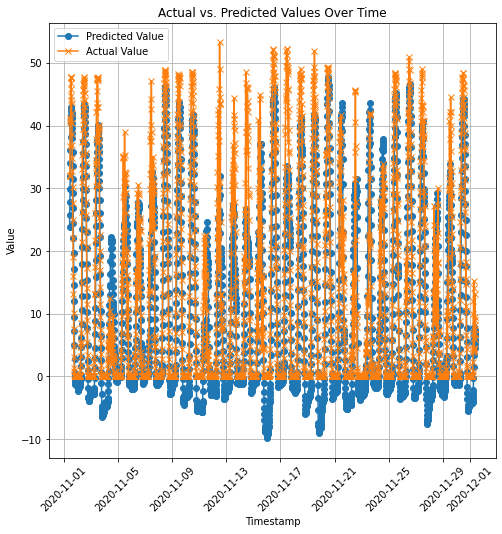

In [24]:
plt.figure(figsize=(8, 8))
plt.plot(df0.index, df0['Predicted'], label='Predicted Value', marker='o')
plt.plot(df0.index, df0['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [25]:
original_accuracy_0=r2_score(Y_test, solar_0)

# log predict small value

In [26]:
# solar_0_train['log']=np.log(solar_0_train['power_output']+10**(-3))
# solar_0_test_1['log']=np.log(solar_0_test_1['power_output']+10**(-3))
# #train_split_mod
# X_train_log=solar_0_train.drop(['power_output','solar_no','log'],axis=1)
# X_test_log= solar_0_test_1.drop(['power_output','solar_no','log'],axis=1)
# Y_train_log=solar_0_train['log']
# Y_test_log = solar_0_test_1['log']

In [27]:
#train_split_mod is a function provide a table to calculate the r^2square and soon.
# train_split_mod(X_train_log,X_test_log,Y_train_log,Y_test_log)

In [28]:
#get the predicted value
# solar_0_log=predic_value(X_train_log,X_test_log,Y_train_log,Y_test_log)

In [29]:
#exp of the predicted value
# solar_0_log_1=np.exp(solar_0_log)

In [30]:
# solar_0_log_1

In [31]:
#tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df0_log=tab(solar_0_log_1,solar_0_test_1)
# df0_log

In [32]:
# small_log_accuracy_0=r2_score(solar_0_test_1['power_output'],solar_0_log_1)

# log plus one

In [33]:
#use this function to create a new column call "log_1" in the solatr dataframe.
# solar_0_test_1['log_1']=np.log(solar_0_test_1['power_output']+1)
# solar_0_train['log_1']=np.log(solar_0_train['power_output']+1)
# #drop all the values that don;t need for training data madel.
# X_train_log_plus_1=solar_0_train.drop(['power_output','solar_no','log','log_1'],axis=1)
# X_test_log_plus_1= solar_0_test_1.drop(['power_output','solar_no','log','log_1'],axis=1)
# Y_train_log_plus_1=solar_0_train['log_1']
# Y_test_log_plus_1 = solar_0_test_1['log_1']


In [34]:
#tran_split_mod is a function that create by me to get the r^2 value, rmse and Mae of the training model.
# train_split_mod(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [35]:
#the predicted_value function will provide the predicted value for the model
# solar_0_log_plus_1=predic_value(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [36]:
#this one shows thw minimum of the predictd value
# min(solar_0_log_plus_1)


In [37]:
#set all the predicted value which less than 0 to 0
# solar_0_log_plus_1[solar_0_log_plus_1<0]=0
# #test whether it works or not
# min(solar_0_log_plus_1)


In [38]:
#do the exponetian of the predicted value and minus 1 to turn the data back
# solar_0_log_plus_1=np.exp(solar_0_log_plus_1)-1


In [39]:
#tab3 is a function the provide two array, and combined them as a dataFrame.
# df0_log_plus_tab=tab(solar_0_log_plus_1,solar_0_test_1)
# df0_log_plus_tab


In [40]:
#get the r^2 square value of the y_test data and the predicted data.
# plus_1_log_accuracy_0=r2_score(solar_0_test_1['power_output'],solar_0_log_plus_1)

# absolute

In [41]:
df0_2=df0
df0_2[df0_2<0]=0

In [42]:
absolute_accuracy_0=r2_score(df0_2['Actual'],df0_2['Predicted'])

# normalization

In [43]:
X_train_norm=solar_0_train.drop(['power_output','solar_no'],axis=1)
X_test_norm= solar_0_test_1.drop(['power_output','solar_no'],axis=1)
Y_train_norm=solar_0_train['power_output']
Y_test_norm = solar_0_test_1['power_output']
X_train_norm=preprocessing.normalize(X_train_norm)
X_test_norm=preprocessing.normalize(X_test_norm)
train_split_mod(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)
solar_0_norm=predic_value(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)


In [44]:
min(solar_0_norm)

-10.503837947908323

In [45]:
norm_0=r2_score(Y_test_norm,solar_0_norm)

In [46]:
df0_norm_tab=tab(solar_0_norm,solar_0_test_1)
df0_norm_tab.set_index('timestamp', inplace=True)
df0_norm_tab

,Predicted,Actual
timestamp,,
2020-11-01 10:00:00,23.676580,31.90
2020-11-01 10:15:00,26.025390,32.02
2020-11-01 10:30:00,28.443025,32.14
2020-11-01 10:45:00,30.929486,36.68
2020-11-01 11:00:00,33.484774,41.22
...,...,...
2020-12-01 08:45:00,5.994786,13.21
2020-12-01 09:00:00,5.729830,8.24
2020-12-01 09:15:00,5.094294,9.42


# norm abs

In [47]:
df0_norm_tab_abs=df0_norm_tab
df0_norm_tab_abs[df0_norm_tab_abs<0]=0

norm_absolute_accuracy_0=r2_score(df0_norm_tab_abs['Actual'],df0_norm_tab_abs['Predicted'])

In [48]:
a=min(df0_norm_tab_abs['Predicted'])

# result

In [49]:
original_accuracy_0

0.8156063464022092

In [50]:
norm_0

0.8082444041531991

In [51]:
norm_absolute_accuracy_0

0.8268395153571078

In [52]:
absolute_accuracy_0

0.8347778867483554

# solar 1

In [53]:
X_train=solar_1_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_1_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_1_train['power_output']
Y_test = solar_1_test_1['power_output']

In [54]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.594573,2.411787,1.717086
test,0.850433,1.650854,1.211836


In [55]:
solar_1=predic_value(X_train,X_test,Y_train,Y_test)
df1=tab(solar_1,solar_1_test_1)
df1

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,6.980013,7.95
1,2020-11-01 10:15:00,7.460032,8.51
2,2020-11-01 10:30:00,7.940052,9.07
3,2020-11-01 10:45:00,8.420071,9.38
4,2020-11-01 11:00:00,8.900090,9.68
...,...,...,...
2875,2020-12-01 08:45:00,3.088772,2.32
2876,2020-12-01 09:00:00,3.069167,2.21
2877,2020-12-01 09:15:00,2.907732,2.00
2878,2020-12-01 09:30:00,2.746296,1.78


In [56]:
df1.set_index('timestamp', inplace=True)

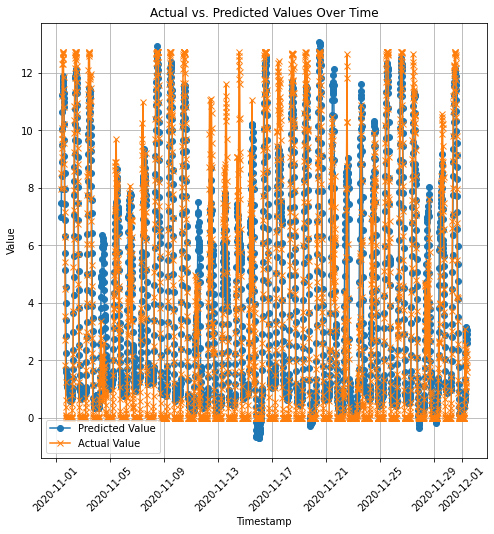

In [57]:
plt.figure(figsize=(8, 8))
plt.plot(df1.index, df1['Predicted'], label='Predicted Value', marker='o')
plt.plot(df1.index, df1['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [58]:
original_accuracy_1=r2_score(Y_test,solar_1)

In [59]:
# solar_1_log=np.log2(solar_1+abs(min(solar_1))+1)
# solar_1_test_1['logarithm_base2_1']=np.log2(Y_test+1+abs(min(solar_1)))
# log_accuracy_1=r2_score(solar_1_test_1['logarithm_base2_1'],solar_1_log)

# log predice small value

In [60]:
# solar_1_train['log']=np.log(solar_1_train['power_output']+10**(-3))
# solar_1_test_1['log']=np.log(solar_1_test_1['power_output']+10**(-3))
# #train_split_mod
# X_train_log=solar_1_train.drop(['power_output','solar_no','log'],axis=1)
# X_test_log= solar_1_test_1.drop(['power_output','solar_no','log'],axis=1)
# Y_train_log=solar_1_train['log']
# Y_test_log = solar_1_test_1['log']


In [61]:
#train_split_mod is a function provide a table to calculate the r^2square and soon.
# train_split_mod(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [62]:
#get the predicted value
# solar_1_log=predic_value(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [63]:
#exp of the predicted value
# solar_1_log_1=np.exp(solar_1_log)


In [64]:
# #tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df1_log=tab(solar_1_log_1,solar_1_test_1)
# df1_log

In [65]:
# small_log_accuracy_1=r2_score(solar_1_test_1['power_output'],solar_1_log_1)

# log plus 1

In [66]:
#use this function to create a new column call "log_1" in the solatr dataframe.
# solar_1_test_1['log_1']=np.log(solar_1_test_1['power_output']+1)
# solar_1_train['log_1']=np.log(solar_1_train['power_output']+1)
# #drop all the values that don;t need for training data madel.
# X_train_log_plus_1=solar_1_train.drop(['power_output','solar_no','log','log_1'],axis=1)
# X_test_log_plus_1= solar_1_test_1.drop(['power_output','solar_no','log','log_1'],axis=1)
# Y_train_log_plus_1=solar_1_train['log_1']
# Y_test_log_plus_1 = solar_1_test_1['log_1']


In [67]:
#tran_split_mod is a function that create by me to get the r^2 value, rmse and Mae of the training model.
# train_split_mod(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [68]:
#the predicted_value function will provide the predicted value for the model
# solar_1_log_plus_1=predic_value(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [69]:
#this one shows thw minimum of the predictd value
# min(solar_1_log_plus_1)


In [70]:
#set all the predicted value which less than 0 to 0
# solar_1_log_plus_1[solar_1_log_plus_1<0]=0
# #test whether it works or not
# min(solar_1_log_plus_1)

In [71]:
#do the exponetian of the predicted value and minus 1 to turn the data back
# solar_1_log_plus_1=np.exp(solar_1_log_plus_1)-1

In [72]:
#tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df1_log_plus_tab=tab(solar_1_log_plus_1,solar_1_test_1)


In [73]:
#get the r^2 square value of the y_test data and the predicted data.
# plus_1_log_accuracy_1=r2_score(solar_1_test_1['power_output'],solar_1_log_plus_1)

# absolute

In [74]:
df1_2=df1
df1_2[df1_2<0]=0

In [75]:
absolute_accuracy_1=r2_score(df1_2['Actual'],df1_2['Predicted'])

# normalization

In [76]:
X_train_norm=solar_1_train.drop(['power_output','solar_no'],axis=1)
X_test_norm= solar_1_test_1.drop(['power_output','solar_no'],axis=1)
Y_train_norm=solar_1_train['power_output']
Y_test_norm = solar_1_test_1['power_output']
X_train_norm=preprocessing.normalize(X_train_norm)
X_test_norm=preprocessing.normalize(X_test_norm)
train_split_mod(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)
solar_1_norm=predic_value(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)



In [77]:
min(solar_1_norm)

-0.7357472659132327

In [78]:
norm_1=r2_score(Y_test_norm,solar_1_norm)

In [79]:
df1_norm_tab=tab(solar_1_norm,solar_1_test_1)
df1_norm_tab.set_index('timestamp', inplace=True)
df1_norm_tab

,Predicted,Actual
timestamp,,
2020-11-01 10:00:00,6.905709,7.95
2020-11-01 10:15:00,7.363978,8.51
2020-11-01 10:30:00,7.816792,9.07
2020-11-01 10:45:00,8.264149,9.38
2020-11-01 11:00:00,8.706050,9.68
...,...,...
2020-12-01 08:45:00,3.316910,2.32
2020-12-01 09:00:00,3.293040,2.21
2020-12-01 09:15:00,3.108465,2.00


# norma abs

In [80]:
df1_norm_tab_abs=df1_norm_tab
df1_norm_tab_abs[df1_norm_tab_abs<0]=0

norm_absolute_accuracy_1=r2_score(df1_norm_tab_abs['Actual'],df1_norm_tab_abs['Predicted'])

In [81]:
b=min(df1_norm_tab_abs['Predicted'])

# normalization absolute

# result

In [82]:
original_accuracy_1

0.8504333841246651

In [83]:
norm_1

0.8473718418672415

In [84]:
norm_absolute_accuracy_1

0.8475658617343826

In [85]:
absolute_accuracy_1

0.850612115566773

# solar 2

In [86]:
X_train=solar_2_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_2_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_2_train['power_output']
Y_test = solar_2_test_1['power_output']

In [87]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.762695,1.650633,1.135749
test,0.860785,1.589145,1.044817


In [88]:
solar_2=predic_value(X_train,X_test,Y_train,Y_test)

df2=tab(solar_2,solar_2_test_1)
df2

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,6.608176,8.26
1,2020-11-01 10:15:00,7.101089,8.11
2,2020-11-01 10:30:00,7.594002,7.95
3,2020-11-01 10:45:00,8.086915,9.12
4,2020-11-01 11:00:00,8.579829,10.29
...,...,...,...
2875,2020-12-01 08:45:00,2.523492,2.21
2876,2020-12-01 09:00:00,2.472387,2.10
2877,2020-12-01 09:15:00,2.320666,1.90
2878,2020-12-01 09:30:00,2.168945,1.70


In [89]:
df2.set_index('timestamp', inplace=True)

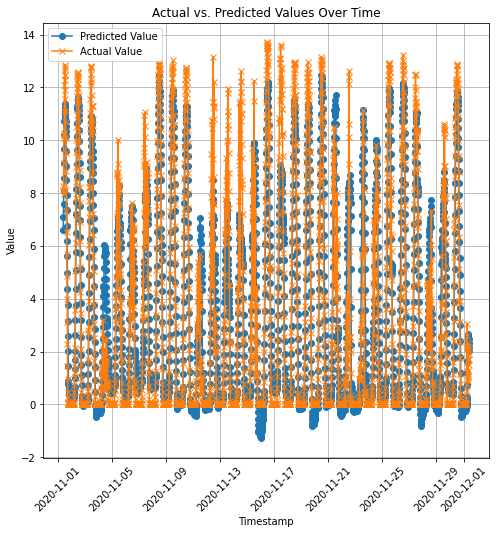

In [90]:
plt.figure(figsize=(8, 8))
plt.plot(df2.index, df2['Predicted'], label='Predicted Value', marker='o')
plt.plot(df2.index, df2['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [91]:
original_accuracy_2=r2_score(Y_test,solar_2)

In [92]:
# solar_2_log=np.log2(solar_2+abs(min(solar_2))+1)
# solar_2_test_1['logarithm_base2_1']=np.log2(Y_test+1+abs(min(solar_2)))
# log_accuracy_2=r2_score(solar_2_test_1['logarithm_base2_1'],solar_2_log)

# log predict small value

In [93]:
# solar_2_train['log']=np.log(solar_2_train['power_output']+10**(-3))
# solar_2_test_1['log']=np.log(solar_2_test_1['power_output']+10**(-3))
# #train_split_mod
# X_train_log=solar_2_train.drop(['power_output','solar_no','log'],axis=1)
# X_test_log= solar_2_test_1.drop(['power_output','solar_no','log'],axis=1)
# Y_train_log=solar_2_train['log']
# Y_test_log = solar_2_test_1['log']


In [94]:
#train_split_mod is a function provide a table to calculate the r^2square and soon.
# train_split_mod(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [95]:
#get the predicted value
# solar_2_log=predic_value(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [96]:
#exp of the predicted value
# solar_2_log_1=np.exp(solar_2_log)


In [97]:
#tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df2_log=tab(solar_2_log_1,solar_2_test_1)
# df2_log

In [98]:
# small_log_accuracy_2=r2_score(solar_2_test_1['power_output'],solar_2_log_1)

# log plus 1

In [99]:
#use this function to create a new column call "log_1" in the solatr dataframe.
# solar_2_test_1['log_1']=np.log(solar_2_test_1['power_output']+1)
# solar_2_train['log_1']=np.log(solar_2_train['power_output']+1)
# #drop all the values that don;t need for training data madel.
# X_train_log_plus_1=solar_2_train.drop(['power_output','solar_no','log','log_1'],axis=1)
# X_test_log_plus_1= solar_2_test_1.drop(['power_output','solar_no','log','log_1'],axis=1)
# Y_train_log_plus_1=solar_2_train['log_1']
# Y_test_log_plus_1 = solar_2_test_1['log_1']

In [100]:
#tran_split_mod is a function that create by me to get the r^2 value, rmse and Mae of the training model.
# train_split_mod(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [101]:
#the predicted_value function will provide the predicted value for the model
# solar_2_log_plus_1=predic_value(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [102]:
#this one shows thw minimum of the predictd value
# min(solar_2_log_plus_1)

In [103]:
#set all the predicted value which less than 0 to 0
# solar_2_log_plus_1[solar_2_log_plus_1<0]=0
# #test whether it works or not
# min(solar_2_log_plus_1)

In [104]:
#do the exponetian of the predicted value and minus 1 to turn the data back
# solar_2_log_plus_1=np.exp(solar_2_log_plus_1)-1


In [105]:
#tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df2_log_plus_tab=tab(solar_2_log_plus_1,solar_2_test_1)


In [106]:
#get the r^2 square value of the y_test data and the predicted data.
# plus_1_log_accuracy_2=r2_score(solar_2_test_1['power_output'],solar_2_log_plus_1)

# absolute

In [107]:
df2_2=df2
df2_2[df2_2<0]=0

In [108]:
absolute_accuracy_2=r2_score(df2_2['Actual'],df2_2['Predicted'])

# noramalization

In [109]:
X_train_norm=solar_2_train.drop(['power_output','solar_no'],axis=1)
X_test_norm= solar_2_test_1.drop(['power_output','solar_no'],axis=1)
Y_train_norm=solar_2_train['power_output']
Y_test_norm = solar_2_test_1['power_output']
X_train_norm=preprocessing.normalize(X_train_norm)
X_test_norm=preprocessing.normalize(X_test_norm)
train_split_mod(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)
solar_2_norm=predic_value(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)



In [110]:
min(solar_2_norm)

-1.3263460262337503

In [111]:
norm_2=r2_score(Y_test_norm,solar_2_norm)

In [112]:
df2_norm_tab=tab(solar_2_norm,solar_2_test_1)
df2_norm_tab.set_index('timestamp', inplace=True)
df2_norm_tab

,Predicted,Actual
timestamp,,
2020-11-01 10:00:00,6.496684,8.26
2020-11-01 10:15:00,6.983413,8.11
2020-11-01 10:30:00,7.470645,7.95
2020-11-01 10:45:00,7.958380,9.12
2020-11-01 11:00:00,8.446618,10.29
...,...,...
2020-12-01 08:45:00,2.601459,2.21
2020-12-01 09:00:00,2.557710,2.10
2020-12-01 09:15:00,2.393482,1.90


# norma abs

In [113]:
df2_norm_tab_abs=df2_norm_tab
df2_norm_tab_abs[df2_norm_tab_abs<0]=0

norm_absolute_accuracy_2=r2_score(df2_norm_tab_abs['Actual'],df2_norm_tab_abs['Predicted'])

In [114]:
c=min(df2_norm_tab_abs['Predicted'])

# result

In [115]:
original_accuracy_2

0.8607848142927548

In [116]:
norm_2

0.8603680544114283

In [117]:
norm_absolute_accuracy_2

0.8615411912819321

In [118]:
absolute_accuracy_2

0.8619785722792949

# solar 3

In [119]:
X_train=solar_3_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_3_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_3_train['power_output']
Y_test = solar_3_test_1['power_output']

In [120]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.687693,1.376517,0.859645
test,0.781041,1.784517,1.179812


In [121]:

solar_3=predic_value(X_train,X_test,Y_train,Y_test)

df3=tab(solar_3,solar_3_test_1)
df3

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,4.678501,7.69
1,2020-11-01 10:15:00,5.014036,7.52
2,2020-11-01 10:30:00,5.349571,7.35
3,2020-11-01 10:45:00,5.685107,8.15
4,2020-11-01 11:00:00,6.020642,8.96
...,...,...,...
2875,2020-12-01 08:45:00,1.673425,3.11
2876,2020-12-01 09:00:00,1.656515,1.97
2877,2020-12-01 09:15:00,1.539310,2.24
2878,2020-12-01 09:30:00,1.422105,1.78


In [122]:
df3.set_index('timestamp', inplace=True)

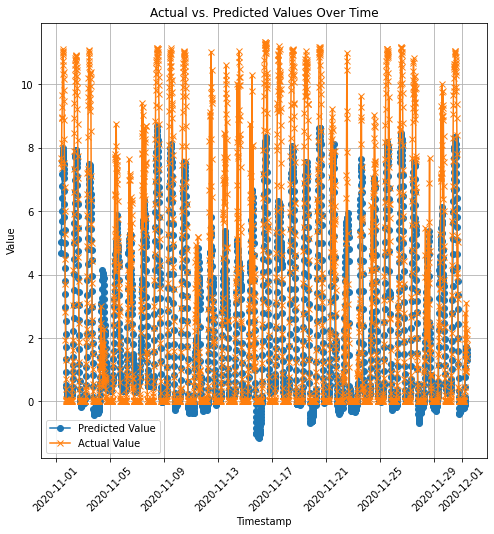

In [123]:
plt.figure(figsize=(8, 8))
plt.plot(df3.index, df3['Predicted'], label='Predicted Value', marker='o')
plt.plot(df3.index, df3['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [124]:
original_accuracy_3=r2_score(Y_test,solar_3)

In [125]:
# solar_3_log=np.log2(solar_3+abs(min(solar_3))+1)
# solar_3_test_1['logarithm_base2_1']=np.log2(Y_test+1+abs(min(solar_3)))
# log_accuracy_3=r2_score(solar_3_test_1['logarithm_base2_1'],solar_3_log)

# log predict small value

In [126]:
# solar_3_train['log']=np.log(solar_3_train['power_output']+10**(-3))
# solar_3_test_1['log']=np.log(solar_3_test_1['power_output']+10**(-3))
# #train_split_mod
# X_train_log=solar_3_train.drop(['power_output','solar_no','log'],axis=1)
# X_test_log= solar_3_test_1.drop(['power_output','solar_no','log'],axis=1)
# Y_train_log=solar_3_train['log']
# Y_test_log = solar_3_test_1['log']


In [127]:
#train_split_mod is a function provide a table to calculate the r^2square and soon.
# train_split_mod(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [128]:
#get the predicted value
# solar_3_log=predic_value(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [129]:
#exp of the predicted value
# solar_3_log_1=np.exp(solar_0_log)


In [130]:
#tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df3_log=tab(solar_3_log_1,solar_3_test_1)
# df3_log

In [131]:
# small_log_accuracy_3=r2_score(solar_3_test_1['power_output'],solar_3_log_1)

# log plus 1

In [132]:
#use this function to create a new column call "log_1" in the solatr dataframe.
# solar_3_test_1['log_1']=np.log(solar_3_test_1['power_output']+1)
# solar_3_train['log_1']=np.log(solar_3_train['power_output']+1)
# #drop all the values that don;t need for training data madel.
# X_train_log_plus_1=solar_3_train.drop(['power_output','solar_no','log','log_1'],axis=1)
# X_test_log_plus_1= solar_3_test_1.drop(['power_output','solar_no','log','log_1'],axis=1)
# Y_train_log_plus_1=solar_3_train['log_1']
# Y_test_log_plus_1 = solar_3_test_1['log_1']


In [133]:
#tran_split_mod is a function that create by me to get the r^2 value, rmse and Mae of the training model.
# train_split_mod(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [134]:
#the predicted_value function will provide the predicted value for the model
# solar_3_log_plus_1=predic_value(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [135]:
#this one shows thw minimum of the predictd value
# min(solar_3_log_plus_1)


In [136]:
# #set all the predicted value which less than 0 to 0
# solar_3_log_plus_1[solar_3_log_plus_1<0]=0
# #test whether it works or not
# min(solar_3_log_plus_1)


In [137]:
#do the exponetian of the predicted value and minus 1 to turn the data back
# solar_3_log_plus_1=np.exp(solar_3_log_plus_1)-1


In [138]:
# #tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df3_log_plus_tab=tab(solar_3_log_plus_1,solar_3_test_1)
# df3_log_plus_tab

In [139]:
# #get the r^2 square value of the y_test data and the predicted data.
# plus_1_log_accuracy_3=r2_score(solar_3_test_1['power_output'],solar_3_log_plus_1)

# absolute

In [140]:
df3_2=df3
df3_2[df3_2<0]=0

In [141]:
absolute_accuracy_3=r2_score(df3_2['Actual'],df3_2['Predicted'])

# normalization

In [142]:
X_train_norm=solar_3_train.drop(['power_output','solar_no'],axis=1)
X_test_norm= solar_3_test_1.drop(['power_output','solar_no'],axis=1)
Y_train_norm=solar_3_train['power_output']
Y_test_norm = solar_3_test_1['power_output']
X_train_norm=preprocessing.normalize(X_train_norm)
X_test_norm=preprocessing.normalize(X_test_norm)
train_split_mod(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)
solar_3_norm=predic_value(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)



In [143]:
min(solar_3_norm)

-1.1606050117698032

In [144]:
norm_3=r2_score(Y_test_norm,solar_3_norm)

In [145]:
df3_norm_tab=tab(solar_3_norm,solar_3_test_1)
df3_norm_tab.set_index('timestamp', inplace=True)
df3_norm_tab

,Predicted,Actual
timestamp,,
2020-11-01 10:00:00,4.810976,7.69
2020-11-01 10:15:00,5.110961,7.52
2020-11-01 10:30:00,5.397941,7.35
2020-11-01 10:45:00,5.671917,8.15
2020-11-01 11:00:00,5.932888,8.96
...,...,...
2020-12-01 08:45:00,1.914782,3.11
2020-12-01 09:00:00,1.867775,1.97
2020-12-01 09:15:00,1.737131,2.24


# normalization abs

In [146]:
df3_norm_tab_abs=df3_norm_tab
df3_norm_tab_abs[df3_norm_tab_abs<0]=0

norm_absolute_accuracy_3=r2_score(df3_norm_tab_abs['Actual'],df3_norm_tab_abs['Predicted'])

In [147]:
d=min(df3_norm_tab_abs['Predicted'])

# result

In [148]:
original_accuracy_3

0.7810406858816148

In [149]:
norm_3

0.7616324558507553

In [150]:
norm_absolute_accuracy_3

0.7635347856438087

In [151]:
absolute_accuracy_3

0.782493709172521

# solar 4

In [152]:
X_train=solar_4_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_4_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_4_train['power_output']
Y_test = solar_4_test_1['power_output']

In [153]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.792690,0.92927,0.633757
test,0.842064,1.00399,0.661171


In [154]:
solar_4=predic_value(X_train,X_test,Y_train,Y_test)

df4=tab(solar_4,solar_4_test_1)
df4

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,3.943257,5.13
1,2020-11-01 10:15:00,4.245235,5.01
2,2020-11-01 10:30:00,4.547214,4.89
3,2020-11-01 10:45:00,4.849192,5.59
4,2020-11-01 11:00:00,5.151171,6.29
...,...,...,...
2875,2020-12-01 08:45:00,1.461221,1.31
2876,2020-12-01 09:00:00,1.428522,1.25
2877,2020-12-01 09:15:00,1.329804,1.13
2878,2020-12-01 09:30:00,1.231085,1.01


In [155]:
df4.set_index('timestamp', inplace=True)

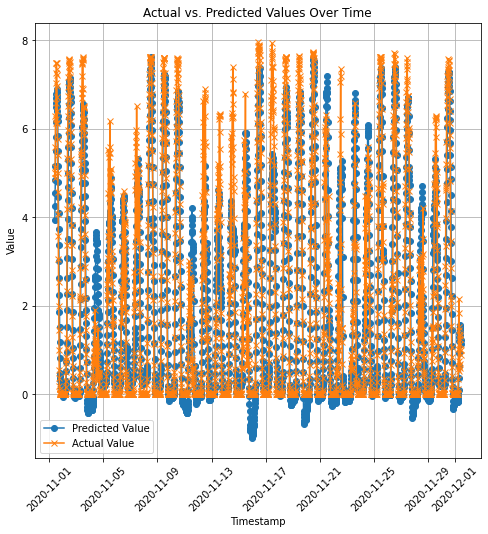

In [156]:
plt.figure(figsize=(8, 8))
plt.plot(df4.index, df4['Predicted'], label='Predicted Value', marker='o')
plt.plot(df4.index, df4['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [157]:
original_accuracy_4=r2_score(Y_test,solar_4)

In [158]:
# solar_4_log=np.log2(solar_4+abs(min(solar_4))+1)
# solar_4_test_1['logarithm_base2_1']=np.log2(Y_test+1+abs(min(solar_4)))
# log_accuracy_4=r2_score(solar_4_test_1['logarithm_base2_1'],solar_4_log)

# log predict small value

In [159]:
# solar_4_train['log']=np.log(solar_4_train['power_output']+10**(-3))
# solar_4_test_1['log']=np.log(solar_4_test_1['power_output']+10**(-3))
# #train_split_mod
# X_train_log=solar_4_train.drop(['power_output','solar_no','log'],axis=1)
# X_test_log= solar_4_test_1.drop(['power_output','solar_no','log'],axis=1)
# Y_train_log=solar_4_train['log']
# Y_test_log = solar_4_test_1['log']


In [160]:
#train_split_mod is a function provide a table to calculate the r^2square and soon.
# train_split_mod(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [161]:
#get the predicted value
# solar_4_log=predic_value(X_train_log,X_test_log,Y_train_log,Y_test_log)


In [162]:
#exp of the predicted value
# solar_4_log_1=np.exp(solar_4_log)


In [163]:
#tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df4_log=tab(solar_4_log_1,solar_4_test_1)
# df4_log

In [164]:
# small_log_accuracy_4=r2_score(solar_4_test_1['power_output'],solar_4_log_1)

# log plus 1

In [165]:
#use this function to create a new column call "log_1" in the solatr dataframe.
# solar_4_test_1['log_1']=np.log(solar_4_test_1['power_output']+1)
# solar_4_train['log_1']=np.log(solar_4_train['power_output']+1)
# #drop all the values that don;t need for training data madel.
# X_train_log_plus_1=solar_4_train.drop(['power_output','solar_no','log','log_1'],axis=1)
# X_test_log_plus_1= solar_4_test_1.drop(['power_output','solar_no','log','log_1'],axis=1)
# Y_train_log_plus_1=solar_4_train['log_1']
# Y_test_log_plus_1 = solar_4_test_1['log_1']

In [166]:
#tran_split_mod is a function that create by me to get the r^2 value, rmse and Mae of the training model.
# train_split_mod(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)


In [167]:
#the predicted_value function will provide the predicted value for the model
# solar_4_log_plus_1=predic_value(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)
#

In [168]:
#this one shows thw minimum of the predictd value
# min(solar_4_log_plus_1)


In [169]:
#set all the predicted value which less than 0 to 0
# solar_4_log_plus_1[solar_4_log_plus_1<0]=0
# #test whether it works or not
# min(solar_4_log_plus_1)


In [170]:
#do the exponetian of the predicted value and minus 1 to turn the data back
# solar_4_log_plus_1=np.exp(solar_4_log_plus_1)-1


In [171]:
# #tab is a function given 1 array,and 1 dataframe contain power_output, combine to dataframe
# df4_log_plus_tab=tab(solar_4_log_1,solar_4_test_1)
# df4_log_plus_tab


In [172]:
#get the r^2 square value of the y_test data and the predicted data.
# plus_1_log_accuracy_4=r2_score(solar_4_test_1['power_output'],solar_4_log_plus_1)

# absolute

In [173]:
df4_2=df4
df4_2[df4_2<0]=0

In [174]:
absolute_accuracy_4=r2_score(df4_2['Actual'],df4_2['Predicted'])

# normalization

In [175]:
X_train_norm=solar_4_train.drop(['power_output','solar_no'],axis=1)
X_test_norm= solar_4_test_1.drop(['power_output','solar_no'],axis=1)
Y_train_norm=solar_4_train['power_output']
Y_test_norm = solar_4_test_1['power_output']
X_train_norm=preprocessing.normalize(X_train_norm)
X_test_norm=preprocessing.normalize(X_test_norm)
train_split_mod(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)
solar_4_norm=predic_value(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)



In [176]:
min(solar_4_norm)

-1.0202873683956568

In [177]:
norm_4=r2_score(Y_test_norm,solar_4_norm)

In [178]:
df4_norm_tab=tab(solar_4_norm,solar_4_test_1)
df4_norm_tab.set_index('timestamp', inplace=True)
df4_norm_tab

,Predicted,Actual
timestamp,,
2020-11-01 10:00:00,3.922834,5.13
2020-11-01 10:15:00,4.217512,5.01
2020-11-01 10:30:00,4.510729,4.89
2020-11-01 10:45:00,4.802485,5.59
2020-11-01 11:00:00,5.092780,6.29
...,...,...
2020-12-01 08:45:00,1.510816,1.31
2020-12-01 09:00:00,1.476463,1.25
2020-12-01 09:15:00,1.372399,1.13


# normalization absolute

In [179]:
df4_norm_tab_abs=df4_norm_tab
df4_norm_tab_abs[df4_norm_tab_abs<0]=0
e=min(df4_norm_tab_abs['Predicted'])


In [180]:
norm_absolute_accuracy_4=r2_score(df4_norm_tab_abs['Actual'],df4_norm_tab_abs['Predicted'])

# reuslt

In [181]:
original_accuracy_4

0.8420639800493105

In [182]:
norm_4

0.8407952528511409

In [183]:
norm_absolute_accuracy_4

0.843347929223846

In [184]:
absolute_accuracy_4

0.8444581782382121

# solar 5

In [185]:
X_train=solar_5_train.drop(['power_output','solar_no'],axis=1)
X_test= solar_5_test_1.drop(['power_output','solar_no'],axis=1)
Y_train=solar_5_train['power_output']
Y_test = solar_5_test_1['power_output']

In [186]:
train_split_mod(X_train,X_test,Y_train,Y_test)

,R^2,RMSE,MAE
train,0.766220,5.151886,3.103072
test,0.852607,4.937999,3.255646


In [187]:
solar_5=predic_value(X_train,X_test,Y_train,Y_test)

df5=tab(solar_5,solar_5_test_1)
# df5.describe()
df5

,timestamp,Predicted,Actual
0,2020-11-01 10:00:00,19.491853,23.01
1,2020-11-01 10:15:00,21.051453,23.73
2,2020-11-01 10:30:00,22.611053,24.45
3,2020-11-01 10:45:00,24.170654,28.05
4,2020-11-01 11:00:00,25.730254,31.63
...,...,...,...
2875,2020-12-01 08:45:00,6.410113,9.86
2876,2020-12-01 09:00:00,6.198517,6.22
2877,2020-12-01 09:15:00,5.687376,7.14
2878,2020-12-01 09:30:00,5.176235,5.64


In [188]:
df5.set_index('timestamp', inplace=True)

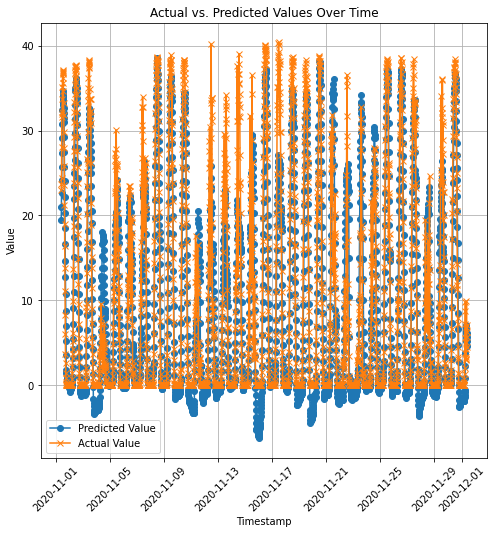

In [189]:

# print(gra)
plt.figure(figsize=(8, 8))
plt.plot(df5.index, df5['Predicted'], label='Predicted Value', marker='o')
plt.plot(df5.index, df5['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [190]:
original_accuracy_5=r2_score(Y_test,solar_5)

# log predict problem

In [191]:
# solar_5_train['log']=np.log(solar_5_train['power_output']+10**(-3))

In [192]:
# solar_5_train

In [193]:
# solar_5_test_1['log']=np.log(solar_5_test_1['power_output']+10**(-3))

In [194]:
# solar_5_test_1

In [195]:
# X_train_log=solar_5_train.drop(['power_output','solar_no','log'],axis=1)
# X_test_log= solar_5_test_1.drop(['power_output','solar_no','log'],axis=1)
# Y_train_log=solar_5_train['log']
# Y_test_log = solar_5_test_1['log']

In [196]:
# train_split_mod(X_train_log,X_test_log,Y_train_log,Y_test_log)

In [197]:
# solar_5_log=predic_value(X_train_log,X_test_log,Y_train_log,Y_test_log)

In [198]:
# solar_5_log

In [199]:
# solar_5_log_1=np.exp(solar_5_log)

In [200]:
# solar_5_log_1

In [201]:
# get the table
# df5_log=tab(solar_5_log_1,solar_5_test_1)
# df5_log

In [202]:
# accuracy
# small_log_accuracy_5=r2_score(solar_5_test_1['power_output'],solar_5_log_1)

# Log_plus_1

In [203]:
#use this function to create a new column call "log_1" in the solatr dataframe.
# solar_5_test_1['log_1']=np.log(solar_5_test_1['power_output']+1)
# solar_5_train['log_1']=np.log(solar_5_train['power_output']+1)

In [204]:
# solar_5_test_1

In [205]:
# solar_5_train

In [206]:
#drop all the values that don;t need for training data madel.
# X_train_log_plus_1=solar_5_train.drop(['power_output','solar_no','log','log_1'],axis=1)
# X_test_log_plus_1= solar_5_test_1.drop(['power_output','solar_no','log','log_1'],axis=1)
# Y_train_log_plus_1=solar_5_train['log_1']
# Y_test_log_plus_1 = solar_5_test_1['log_1']

In [207]:
#tran_split_mod is a function that create by me to get the r^2 value, rmse and Mae of the training model.
# train_split_mod(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)

In [208]:
#the predicted_value function will provide the predicted value for the model
# solar_5_log_plus_1=predic_value(X_train_log_plus_1,X_test_log_plus_1,Y_train_log_plus_1,Y_test_log_plus_1)

In [209]:
#this one shows thw minimum of the predictd value
# min(solar_5_log_plus_1)

In [210]:
#set all the predicted value which less than 0 to 0
# solar_5_log_plus_1[solar_5_log_plus_1<0]=0

In [211]:
#test whether it works or not
# min(solar_5_log_plus_1)

In [212]:
#do the exponetian of the predicted value and minus 1 to turn the data back
# solar_5_log_plus_1=np.exp(solar_5_log_plus_1)-1

In [213]:
#tab3 is a function the provide two array, and combined them as a dataFrame.
# df5_log_plus_tab=tab3(solar_5_log_plus_1,solar_5_test_1['power_output'])#(pred,actu)

In [214]:
# df5_log_plus_tab

In [215]:
#get the r^2 square value of the y_test data and the predicted data.
# plus_1_log_accuracy_5=r2_score(solar_5_test_1['power_output'],solar_5_log_plus_1)

# normalizatin

In [216]:
# X_train_norm=solar_5_train.drop(['power_output','solar_no','log'],axis=1)
# X_test_norm= solar_5_test_1.drop(['power_output','solar_no','log'],axis=1)
# Y_train_norm=solar_5_train['power_output']
# Y_test_norm = solar_5_test_1['power_output']
# X_train_norm=preprocessing.normalize(X_train_norm)
# X_test_norm=preprocessing.normalize(X_test_norm)
# train_split_mod(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)
# solar_5_norm=predic_value(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)
# min(solar_5_norm)
# norm=r2_score(Y_test_norm,solar_5_norm)

In [217]:
X_train_norm=solar_5_train.drop(['power_output','solar_no'],axis=1)
X_test_norm= solar_5_test_1.drop(['power_output','solar_no'],axis=1)
Y_train_norm=solar_5_train['power_output']
Y_test_norm = solar_5_test_1['power_output']

In [218]:
X_train_norm=preprocessing.normalize(X_train_norm)
X_test_norm=preprocessing.normalize(X_test_norm)

In [219]:
# X_train_norm

In [220]:
train_split_mod(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)

,R^2,RMSE,MAE
train,0.766011,5.154189,3.108981
test,0.850510,4.973016,3.327965


In [221]:
solar_5_norm=predic_value(X_train_norm,X_test_norm,Y_train_norm,Y_test_norm)

In [222]:
min(solar_5_norm)

-6.386073691639467

In [223]:
norm_5=r2_score(Y_test_norm,solar_5_norm)

In [224]:
# solar_5_norm

In [225]:
df5_norm_tab=tab(solar_5_norm,solar_5_test_1)
df5_norm_tab.set_index('timestamp', inplace=True)
df5_norm_tab

,Predicted,Actual
timestamp,,
2020-11-01 10:00:00,19.533819,23.01
2020-11-01 10:15:00,21.039037,23.73
2020-11-01 10:30:00,22.529173,24.45
2020-11-01 10:45:00,24.004225,28.05
2020-11-01 11:00:00,25.464193,31.63
...,...,...
2020-12-01 08:45:00,6.736509,9.86
2020-12-01 09:00:00,6.493663,6.22
2020-12-01 09:15:00,5.956420,7.14


In [226]:
# df5_norm_tab_abs=df5_norm_tab
# df5_norm_tab_abs[df5_norm_tab_abs<0]=0
# min(df5_norm_tab_abs['Predicted'])
# norm_absolute_accuracy_5=r2_score(df5_norm_tab_abs['Actual'],df5_norm_tab_abs['Predicted'])

# normalization absolute

In [227]:
df5_norm_tab_abs=df5_norm_tab
df5_norm_tab_abs[df5_norm_tab_abs<0]=0
f=min(df5_norm_tab_abs['Predicted'])

In [228]:
norm_absolute_accuracy_5=r2_score(df5_norm_tab_abs['Actual'],df5_norm_tab_abs['Predicted'])

# out

In [229]:
# norm_absolute_accuracy_5

# absolute

In [230]:
min(df5['Predicted'])
df5_2=df5
df5_2[df5_2<0]=0

In [231]:
min(df5_2['Predicted'])
#0.0

0.0

In [232]:
df5_2

,Predicted,Actual
timestamp,,
2020-11-01 10:00:00,19.491853,23.01
2020-11-01 10:15:00,21.051453,23.73
2020-11-01 10:30:00,22.611053,24.45
2020-11-01 10:45:00,24.170654,28.05
2020-11-01 11:00:00,25.730254,31.63
...,...,...
2020-12-01 08:45:00,6.410113,9.86
2020-12-01 09:00:00,6.198517,6.22
2020-12-01 09:15:00,5.687376,7.14


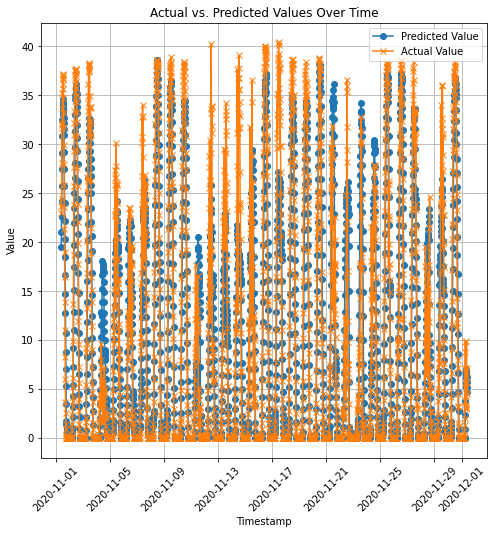

In [233]:
# print(gra)
plt.figure(figsize=(8, 8))
plt.plot(df5_2.index, df5_2['Predicted'], label='Predicted Value', marker='o')
plt.plot(df5_2.index, df5_2['Actual'], label='Actual Value', marker='x')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values Over Time')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
# Show the plot
plt.show()

In [234]:
absolute_accuracy_5=r2_score(df5_2['Actual'],df5_2['Predicted'])

# result

In [235]:
original_accuracy_5

0.8526074257522727

In [236]:
norm_5

0.8505096095908847

In [237]:
norm_absolute_accuracy_5

0.857017416018278

In [238]:
absolute_accuracy_5

0.8585753143925824

In [239]:
df = pd.DataFrame({
    'solar no':['solar 0','solar 1','solar 2','solar 3','solar 4','solar 5'],
    'original accuracy':[original_accuracy_0,original_accuracy_1,original_accuracy_2,original_accuracy_3,
                         original_accuracy_4,original_accuracy_5],
    'absolute accuracy':[absolute_accuracy_0,absolute_accuracy_1,absolute_accuracy_2,absolute_accuracy_3,
                        absolute_accuracy_4,absolute_accuracy_5],
    'normalization original': [norm_0,norm_1,norm_2,norm_3,norm_4,norm_5],
    'normalization original absolute':[norm_absolute_accuracy_0,norm_absolute_accuracy_1,norm_absolute_accuracy_2,
                                      norm_absolute_accuracy_3,norm_absolute_accuracy_4,norm_absolute_accuracy_5]

})
df.set_index('solar no', inplace=True)

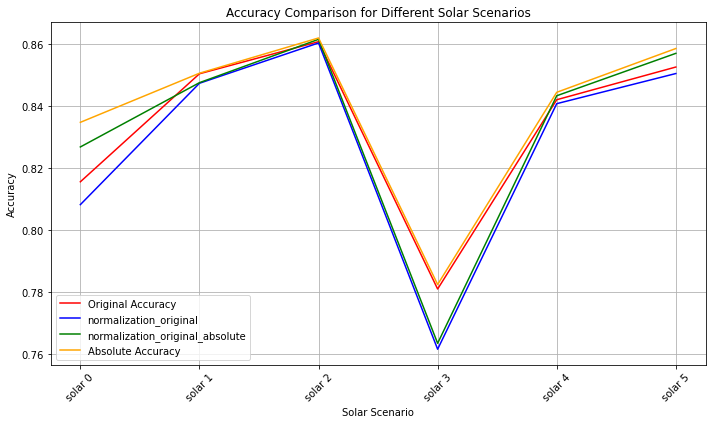

In [240]:
# Extract the data columns from the DataFrame
x = df.index  # 'solar no' values will be on the x-axis
original_accuracy = df['original accuracy']

absolute_accuracy = df['absolute accuracy']
normalization_original = df['normalization original']
normalization_original_absolute=df['normalization original absolute']

# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(x, original_accuracy, label='Original Accuracy', color='red')
plt.plot(x, normalization_original, label='normalization_original', color='blue')
plt.plot(x, normalization_original_absolute, label='normalization_original_absolute', color='green')
plt.plot(x, absolute_accuracy, label='Absolute Accuracy', color='orange')

# Add labels and title
plt.xlabel('Solar Scenario')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Solar Scenarios')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the chart
plt.grid(True)  # Add grid lines (optional)
plt.tight_layout()  # Adjust layout for better appearance (optional)
plt.show()


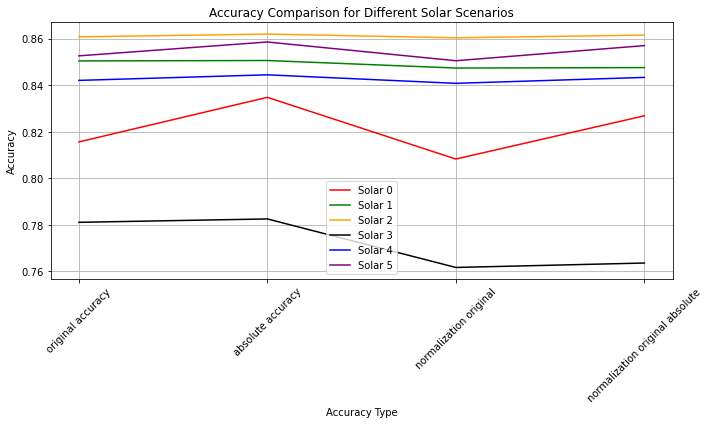

In [241]:
# Transpose the DataFrame so that the columns become the index
df_transposed = df.transpose()

# Create a line chart
plt.figure(figsize=(10, 6))  # Set the figure size (optional)
plt.plot(df_transposed.index, df_transposed['solar 0'], label='Solar 0', color='red')
plt.plot(df_transposed.index, df_transposed['solar 1'], label='Solar 1', color='green')
plt.plot(df_transposed.index, df_transposed['solar 2'], label='Solar 2', color='orange')
plt.plot(df_transposed.index, df_transposed['solar 3'], label='Solar 3', color='black')
plt.plot(df_transposed.index, df_transposed['solar 4'], label='Solar 4', color='blue')
plt.plot(df_transposed.index, df_transposed['solar 5'], label='Solar 5', color='purple')

# Add labels and title
plt.xlabel('Accuracy Type')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison for Different Solar Scenarios')

# Add a legend
plt.legend()

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Display the chart
plt.grid(True)  # Add grid lines (optional)
plt.tight_layout()  # Adjust layout for better appearance (optional)
plt.show()

In [242]:
df

,original accuracy,absolute accuracy,normalization original,normalization original absolute
solar no,,,,
solar 0,0.815606,0.834778,0.808244,0.826840
solar 1,0.850433,0.850612,0.847372,0.847566
solar 2,0.860785,0.861979,0.860368,0.861541
solar 3,0.781041,0.782494,0.761632,0.763535
solar 4,0.842064,0.844458,0.840795,0.843348
solar 5,0.852607,0.858575,0.850510,0.857017
